In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import random
import sys

sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings
import pickle
warnings.filterwarnings("ignore")


In [3]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [5]:
strategy_name = 'LeastConfidence'

In [6]:
nStart = 1
nEnd = 20
nQuery = 2

In [7]:
args_task = {'n_epoch': 60,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 8, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True},
             'loader_te_args': {'batch_size': 4, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True}
             }

In [8]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [9]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)
data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
             'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
             'RNS026.npy', 'RNS029.npy']
# data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

16it [00:03,  4.10it/s]

(992,)
(992,)
(270,)
(270,)


In [10]:
X_train = np.concatenate(train_data)
y_train = np.concatenate(train_label)
X_test = np.concatenate(test_data)
y_test = np.concatenate(test_label)
index_train = np.concatenate(train_index)
index_test = np.concatenate(test_index)
seq_len_train = np.array([y.shape[0] for y in train_label])
seq_len_test = np.array([y.shape[0] for y in test_label])

In [11]:
n_pool = len(train_data)
n_test = len(test_data)

NUM_INIT_LB = int(nStart * n_pool / 100)
NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
if NUM_QUERY != 0:
    if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
        NUM_ROUND += 1

print(NUM_INIT_LB)
print(NUM_QUERY)
print(NUM_ROUND)

9
19
10


In [12]:
dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)

In [13]:
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [14]:
strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data=True)

In [15]:
# initial round of training, round 0
dataset.initialize_labels(NUM_INIT_LB)

In [16]:
# ids,_ = dataset.get_labeled_data()
# 
# selected_inds = {}
# selected_inds[0] = ids
# 
# if not os.path.exists(log_folder_root + 'rns_active_selected/' + strategy_name):
#     os.makedirs(log_folder_root + 'rns_active_selected/' + strategy_name)
# 
# # Serialize and save to a file
# with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
#     pickle.dump(selected_inds, f)

In [17]:
strategy.train()

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

In [18]:

# for rd in range(1, NUM_ROUND + 1):
#     print('round ' + str(rd))
#     log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
#         rd - 1) + '/version_0/metrics.csv'
#     logs = pd.read_csv(log_file_name)
#     max_ind = logs['val_acc'].argmax()
#     max_row = logs.iloc[max_ind]
#     ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
#     ckpt_files = os.listdir(ckpt_directory)
#     load_file_name = strategy_name + '_round_' + str(rd - 1) + '-step=' + str(int(max_row['step']+1))
#     print(load_file_name)
# 
#     ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
#     print(ind, ckpt_files[ind])
#     strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)
# 
#     q_idxs = strategy.query(NUM_QUERY*90)
# 
#     with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
#     # Load the content of the file into a Python object
#         selected_inds = pickle.load(f)
#     selected_inds[rd] = q_idxs
#     with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
#         pickle.dump(selected_inds, f)
# # Now you can use the dictionary object as usual
#     strategy.update(q_idxs)
#     strategy.net.round = rd
#     strategy.net.net.load_state_dict(modelstate)
#     torch.cuda.empty_cache()
#     strategy.train()
#     torch.cuda.empty_cache()

In [20]:
rd = 1
print('round ' + str(rd))
log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
    rd - 1) + '/version_0/metrics.csv'
logs = pd.read_csv(log_file_name)
max_ind = logs['val_acc'].argmax()
max_row = logs.iloc[max_ind]
ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
ckpt_files = os.listdir(ckpt_directory)
load_file_name = strategy_name + '_round_' + str(rd - 1) + '-step=' + str(int(max_row['step']+1))
print(load_file_name)

ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
print(ind, ckpt_files[ind])
strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

q_idxs = strategy.query(NUM_QUERY*90)
# 
# with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
# # Load the content of the file into a Python object
#     selected_inds = pickle.load(f)
# selected_inds[rd] = q_idxs
# with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
#     pickle.dump(selected_inds, f)
# # Now you can use the dictionary object as usual
# strategy.update(q_idxs)
# strategy.net.round = rd
# strategy.net.net.load_state_dict(modelstate)
# torch.cuda.empty_cache()
# strategy.train()
# torch.cuda.empty_cache()

round 1
LeastConfidence_round_0-step=20
0 LeastConfidence_round_0-step=20-train_loss=0.01761.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

total_select_from 13140.0
selected 1711.0


In [21]:
q_idxs

array([ 5711,  5712,  5713, ..., 67852, 67853, 67854])

In [145]:
n = 1700
unlabeled_idxs, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
embeddings, embeddings_t, seq_len  = strategy.get_embeddings(unlabeled_data)




LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [146]:
embeddings = embeddings_t.numpy()
norm_data = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
dist_mat = np.dot(norm_data, norm_data.T)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (992, 3) + inhomogeneous part.

In [149]:
mat = dist_mat[~unlabeled_idxs, :][:, unlabeled_idxs]

for i in tqdm(range(n), ncols=100):
    mat_min = mat.min(axis=1)
    q_idx_ = mat_min.argmax()
    q_idx = np.arange(strategy.dataset.n_pool)[~unlabeled_idxs][q_idx_]
    unlabeled_idxs[q_idx] = True
    mat = np.delete(mat, q_idx_, 0)
    mat = np.append(mat, dist_mat[~unlabeled_idxs, q_idx][:, None], axis=1)

output = np.arange(strategy.dataset.n_pool)[(strategy.dataset.labeled_idxs ^ unlabeled_idxs)]


 55%|█████████████████████████████████                           | 938/1700 [03:41<03:00,  4.23it/s]


KeyboardInterrupt: 

In [150]:
output = np.arange(strategy.dataset.n_pool)[(strategy.dataset.labeled_idxs ^ unlabeled_idxs)]

In [153]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
dis = cos(embeddings_t, embeddings_t[output])

RuntimeError: The size of tensor a (85111) must match the size of tensor b (939) at non-singleton dimension 0

In [158]:
norm_data = embeddings_t / np.linalg.norm(embeddings_t, axis=1, keepdims=True)
norm_data_core = embeddings_t[output]/np.linalg.norm(embeddings_t[output], axis=1, keepdims=True)



In [209]:
similarity_matrix = np.dot(norm_data, norm_data_core.T)
dis = np.min(similarity_matrix,1)

In [211]:
dis[output] = 1

In [141]:
uncertainties_lc = probs.max(1)[0]
to_select_lc = strategy.metrics_distribution_rescaling(uncertainties_lc, seq_len, unlabeled_idxs, n)

total_select_from 13503.0


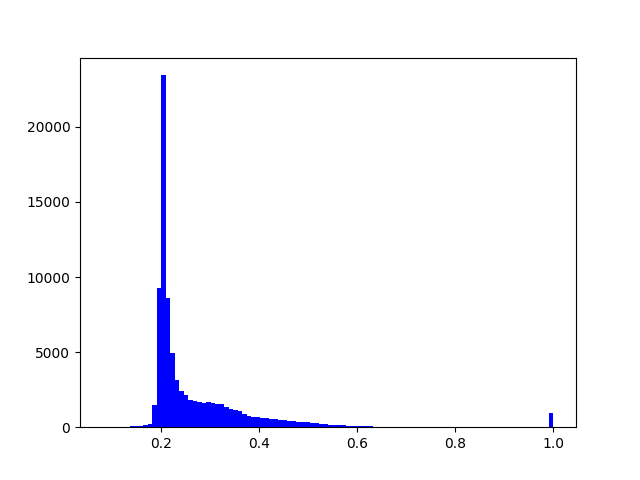

In [212]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(dis, bins=100, color='blue')
plt.show()

In [47]:
def normalize(x):
    return (x-min(x))/(max(x)-min(x))

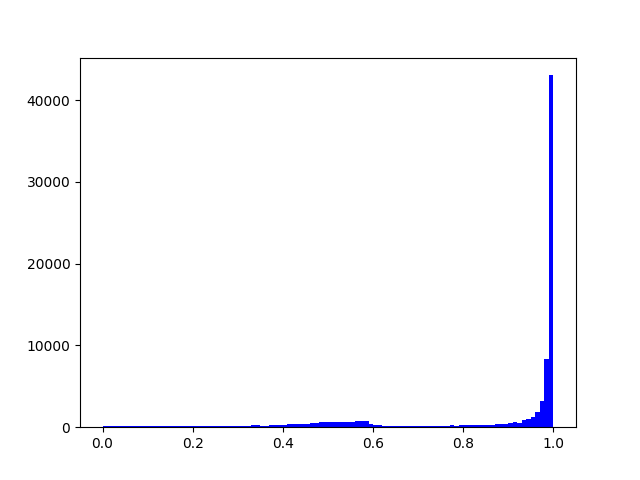

In [66]:
import torch.nn as nn
import matplotlib.pyplot as plt
plt.figure()
plt.hist(normalize(uncertainties_lc), bins=100, color='blue')
plt.show()

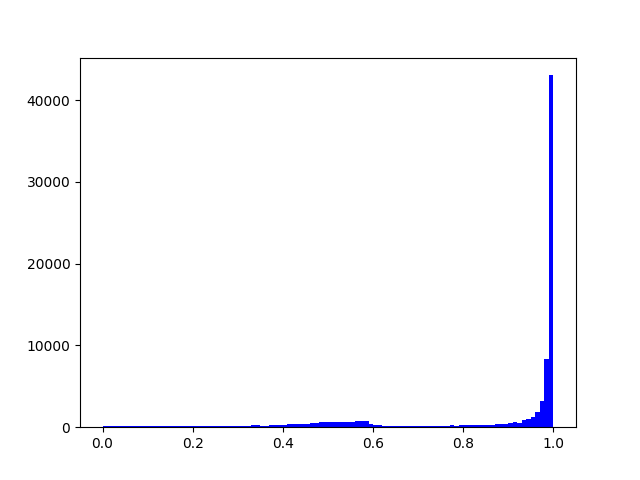

In [67]:
plt.figure()
plt.hist(normalize(uncertainties_mg), bins=100, color='blue')
plt.show()

In [222]:
# indices = np.argsort(-uncertainties)
percentile = 0.15
# uncertainties = dis
uncertainties = -uncertainties
indices = np.argsort(uncertainties)
original_order = indices.argsort()
normalized_data = normalize(uncertainties)
scaling = normalized_data[indices][int(percentile*len(unlabeled_idxs))]
uncertainties_metric = scaling - normalized_data

In [226]:
unlabeled_idxs, unlabeled_data = strategy.dataset.get_unlabeled_data()
probs, seq_len = strategy.predict_prob(unlabeled_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [233]:
unlabeled_idxs

array([    0,     1,     2, ..., 85108, 85109, 85110])

In [228]:
seq_len

tensor([90, 90, 38, 90, 90, 90, 74, 90, 90, 90, 75, 60, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 57, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 30, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 73, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 89,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 89, 90, 90, 90, 90, 90, 58, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 72, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 

In [236]:
random_index = np.random.choice(torch.sum(seq_len), int(n/25))

In [238]:
index_list = []
for ri in random_index:
    index_list.append(np.arange(ri,ri+25))
index_list = np.array(index_list).flatten()
index_list

array([73319, 73320, 73321, ..., 49862, 49863, 49864])

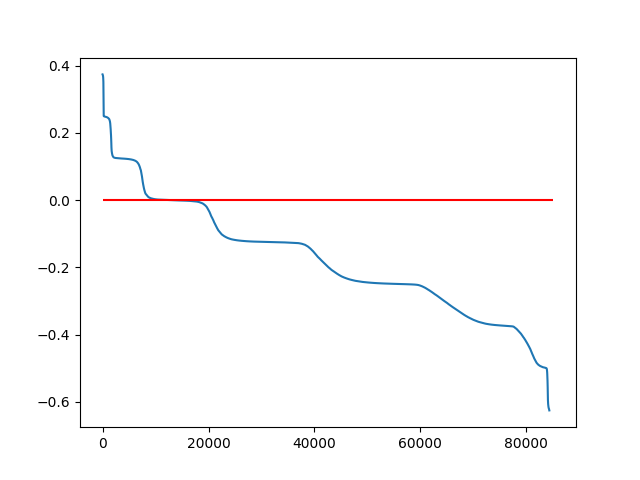

value2 12649


In [223]:
plt.figure()
# plt.plot(value1)
plt.plot(uncertainties_metric[indices])
plt.hlines(0,0,85111,colors='red')
plt.show()
# print('value1', len(np.where(np.sign(value1)>0)[0]))
print('value2', len(np.where(np.sign(uncertainties_metric)>0)[0]))

total_select_from 6953.0
selected 1709.0


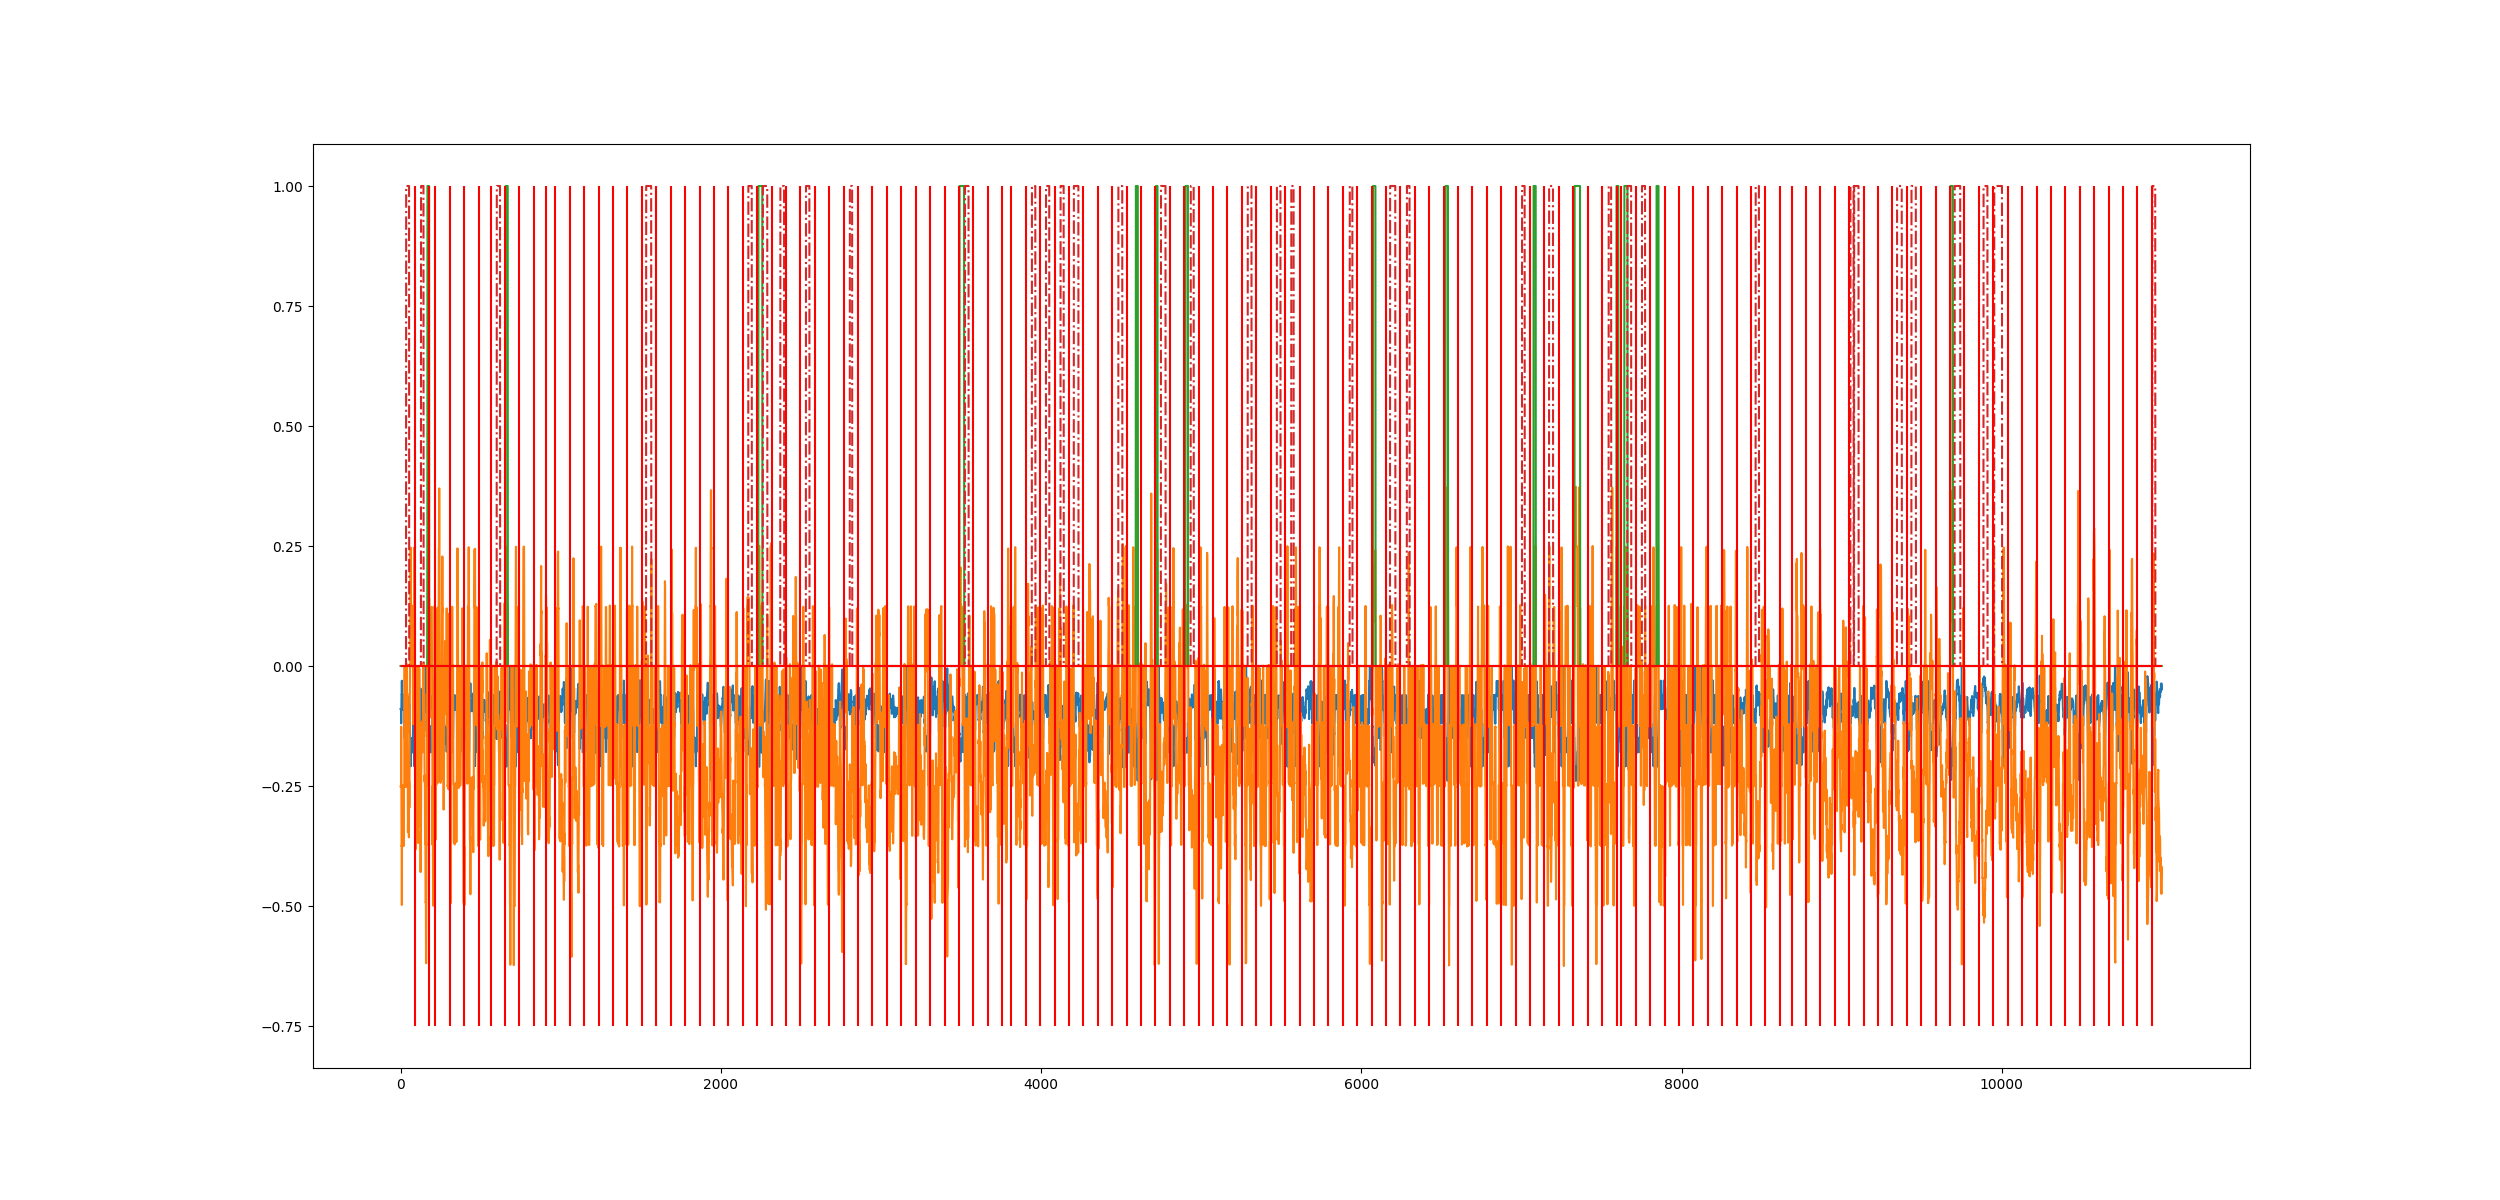

In [225]:

# uncertainties_metric = uncertainties_en

metrics = strategy.dataset.combine_window_to_episode(uncertainties_metric, seq_len)
to_select = strategy.get_combined_important(torch.flatten(seq_len), metrics, n)
print('selected', np.sum(to_select))
to_plot1 = 0
to_plot2 = 11000
import matplotlib.pyplot as plt
x = np.arange(to_plot1,to_plot2)
plt.figure(figsize=(25,12))
plt.plot(x,uncertainties[to_plot1:to_plot2])
plt.plot(x,uncertainties_metric[to_plot1:to_plot2])
plt.plot(x,to_select[to_plot1:to_plot2])
plt.plot(x,np.concatenate(unlabeled_data.label)[to_plot1:to_plot2], '-.')
# plt.plot(x,probs.argmax(1)[to_plot1:to_plot2], '--', color = 'k')
plt.hlines(0,to_plot1,to_plot2,colors='red')
plt.vlines(np.cumsum(seq_len)[np.where((np.cumsum(seq_len)>to_plot1)&(np.cumsum(seq_len)<to_plot2))[0]],-0.75,1, colors='red')
plt.show()

In [140]:
to_select_lc = strategy.metrics_distribution_rescaling(uncertainties_lc, seq_len, unlabeled_idxs, n)

total_select_from 13503.0


In [218]:
unlabeled_idxs, unlabeled_data = strategy.dataset.get_unlabeled_data()
probs, seq_len = strategy.predict_prob_dropout_split(unlabeled_data, n_drop=3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [220]:
sigma_c = np.std(probs.numpy(), axis=0)
uncertainties = torch.from_numpy(np.mean(sigma_c, axis=-1))

In [221]:
uncertainties = strategy.smoothing_prediction(uncertainties, 8)

In [144]:
to_select_lc.sum()

1716.0

In [143]:
to_select_lc

array([0., 0., 0., ..., 0., 0., 0.])

In [44]:
nn.functional.normalize(uncertainties_en,1, 0)

tensor([-1.5840e-06, -6.0376e-07, -5.3963e-07,  ..., -4.3964e-07,
        -4.7238e-07, -9.3536e-07])

In [29]:
log_probs = torch.log(probs)
uncertainties_en = (probs * log_probs).sum(1)
to_select_en = strategy.metrics_distribution_rescaling(uncertainties_en, seq_len, unlabeled_idxs, n)

total_select_from 13140.0


In [34]:
np.argsort(uncertainties_en)

tensor([48311, 45250,  4217,  ...,  7986,  7896,  7686])

In [62]:
probs_sorted, idxs = probs.sort(descending=True)
uncertainties_mg = probs_sorted[:, 0] - probs_sorted[:,1]